## 모듈 import

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')


## 시계열 데이터 준비 dataset loading....

In [40]:
s_dataset_filepath = 'C:/Users/z002t5wz/aiffel/stock_prediction/data/005930.KS.csv'
t_dataset_filepath = 'C:/Users/z002t5wz/aiffel/stock_prediction/data/TSLA.csv'
u_dataset_filepath = 'C:/Users/z002t5wz/aiffel/stock_prediction/data/U.csv'
lazr_dataset_filepath = 'C:/Users/z002t5wz/aiffel/stock_prediction/data/LAZR.csv'
msft_dataset_filepath = 'C:/Users/z002t5wz/aiffel/stock_prediction/data/MSFT.csv'
samsung_df = pd.read_csv(s_dataset_filepath) 
tesla_df = pd.read_csv(t_dataset_filepath) 
u_df = pd.read_csv(u_dataset_filepath) 
lazr_df = pd.read_csv(lazr_dataset_filepath) 
msft_df = pd.read_csv(msft_dataset_filepath) 

## 주가분석

In [45]:
def stock_prediction(df):
        
        # 3. pandas로부터 시계열 데이터 얻기
        ts = df['Close'] 

        # 4. 결측치 확인
        ts.isnull()
        ts[ts.isna()]  # 시계열(Time Series)에서 결측치가 있는 부분만 Series로 출력합니다.

        #isnull() 메소드는 관측치가 결측이면 True, 결측이 아니면 False의 boollean 값을 반환
        if ts.isnull().sum() > 0:
                print("결측치가 있습니다. 전처리를 진행하시고 다시오세요!")
        

        # 5. 로그변환
        plt.plot(ts) # 시계열그래프 확인
        ts_log = np.log(ts) # 로그변환
        plt.plot(ts_log)


        # 6. 시계열 안전성 분석
        # 6.1 정성적 그래프 분석
        def plot_rolling_statistics(timeseries, window=12):  # timeseries 가 series형 변수 (origin)

            rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열 (mean)
            rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열 (std)

            # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
            orig = plt.plot(timeseries, color='blue',label='Original')    
            mean = plt.plot(rolmean, color='red', label='Rolling Mean')
            std = plt.plot(rolstd, color='black', label='Rolling Std')
            plt.legend(loc='best')
            plt.title('Rolling Mean & Standard Deviation')
            plt.show(block=False)

        plot_rolling_statistics(ts_log, window=12)

        
        # 6.2 정량적 Augmented Dicky-Fuller Test
        from statsmodels.tsa.stattools import adfuller

        """주어진 timeseries에 대한 Augmented Dickey-Fuller Test를 수행하는 코드"""

        def augmented_dickey_fuller_test(timeseries):
            dftest = adfuller(timeseries, autolag='AIC')  
            print('Results of Dickey-Fuller Test:')
            dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

            for key,value in dftest[4].items():
                dfoutput['Critical Value (%s)' % key] = value
            print(dfoutput)

        augmented_dickey_fuller_test(ts_log)


        # 7. 시계열 분해(Time Series Decomposition)
        from statsmodels.tsa.seasonal import seasonal_decompose
        decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30)

        """statsmodels 라이브러리 안에는 seasonal_decompose 메서드를 통해 시계열 안에 존재하는 trend, seasonality를 
        직접 분리해 낼 수 있는 기능. 이 기능을 활용하면 우리가 위에서 직접 수행했던 moving average 제거(Trend제거), 
        differencing(seasonality) 등을 거치지 않고도 훨씬 안정적인 시계열을 분리"""

        '''Trend+Seasonality+Residual=Original(ts_log) '''

        trend = decomposition.trend           # 추세(시간 추이에 따라 나타나는 평균값 변화 )
        seasonal = decomposition.seasonal  # 계절성(패턴이 파악되지 않은 주기적 변화)
        residual = decomposition.resid        # 원본(로그변환한) - 추세 - 계절성

        plt.rcParams["figure.figsize"] = (10,6)
        plt.subplot(411)
        plt.plot(ts_log, label='Original')
        plt.legend(loc='best')

        plt.subplot(412)
        plt.plot(trend, label='Trend')
        plt.legend(loc='best')

        plt.subplot(413)
        plt.plot(seasonal,label='Seasonality')
        plt.legend(loc='best')

        plt.subplot(414)
        plt.plot(residual, label='Residuals')
        '''Original 시계열에서 Trend와 Seasonality를 제거하고 난 나머지를 Residual'''
        plt.legend(loc='best')
        plt.tight_layout()

        # 7.1 Original 시계열에서 Trend와 Seasonality를 제거하고 난 나머지를 Residual 이므로 안정성을 확인
        residual
        residual.isna()
        residual[residual.isna()]
        residual.dropna(inplace=True)
        augmented_dickey_fuller_test(residual)
        plt.rcParams["figure.figsize"] = (13,6)
        plot_rolling_statistics(residual)

        # 8. Training, Test set 생성
        train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

        """train_data(90%)와 test_data(10%)를 분리"""

        plt.figure(figsize=(10,6))
        plt.grid(True)
        plt.plot(train_data, c='r', label='training dataset')  
        """train_data를 적용 후 그래프가 끊어져 보임"""
        plt.plot(test_data, c='b', label='test dataset')
        plt.legend()


        train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

        """train_data(90%)와 test_data(10%)를 분리"""

        plt.figure(figsize=(10,6))
        plt.grid(True)
        plt.plot(ts_log, c='r', label='training dataset')  
        """train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택"""
        plt.plot(test_data, c='b', label='test dataset')
        plt.legend()


        # 9. 적정 ARIMA 모수찾기

        from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

        plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
        plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
        plt.show()

        # 9.1 1차분 구하기
        diff_1 = ts_log.diff(periods=1).iloc[1:] 
        """첫번째값의 lag를 구할때는 자기자신과의 차이는 무조건 '1'이기때문에 무시한다."""

        diff_1.plot(title='Difference 1st')

        augmented_dickey_fuller_test(diff_1)

        # 9.2 2차 차분 구하기
        diff_2 = diff_1.diff(periods=1).iloc[1:]
        diff_2.plot(title='Difference 2nd')

        augmented_dickey_fuller_test(diff_2)

        # 10. ARIMA 모델 훈련과 테스트
        import warnings
        warnings.filterwarnings('ignore') #경고 무시

        from statsmodels.tsa.arima.model import ARIMA
        # Build Model
        model = ARIMA(train_data, order=(9, 1, 0)) # p=9 
        fitted_m = model.fit() 

        print(fitted_m.summary())

        # 11. Forecast() 메소드를 이용해 테스트 데이터 구간의 데이터를 예측
        fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
        fc

        # Make as pandas series
        fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

        # Plot
        plt.figure(figsize=(14,7), dpi=100)
        plt.plot(train_data, label='training')
        plt.plot(test_data, c='b', label='actual price')
        plt.plot(fc_series, c='r',label='predicted price')
        plt.legend()
        plt.show()

        from sklearn.metrics import mean_squared_error, mean_absolute_error
        import math

        """fc와 test_data를 지수변환하여 오차를 계산"""

        mse = mean_squared_error(np.exp(test_data), np.exp(fc))
        print('MSE: ', mse)

        mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
        print('MAE: ', mae)

        rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
        print('RMSE: ', rmse)

        mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
        print('MAPE: {:.2f}%'.format(mape*100))

        np.exp(fc)
        plt.plot(np.exp(fc))
        
        return fc 

## 삼성 주가분석

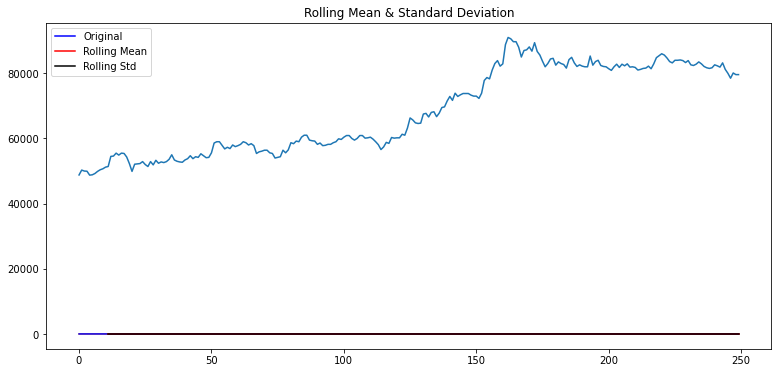

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


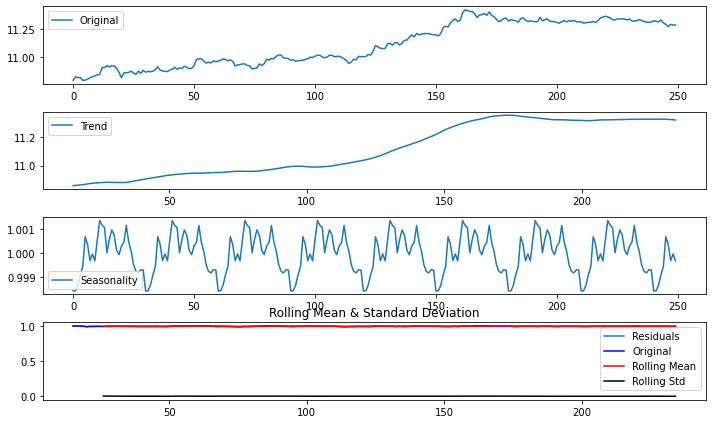

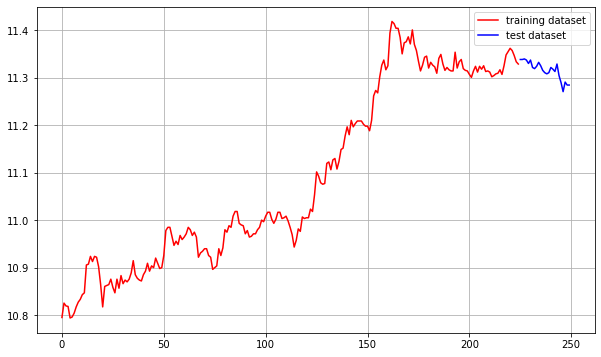

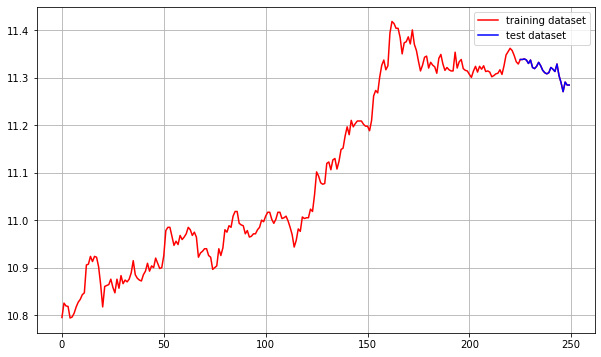

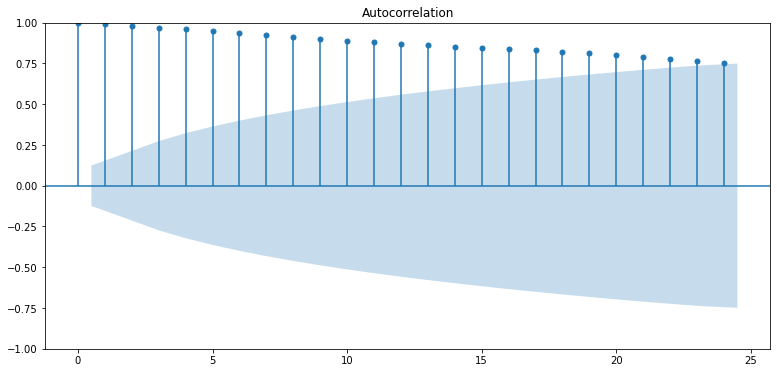

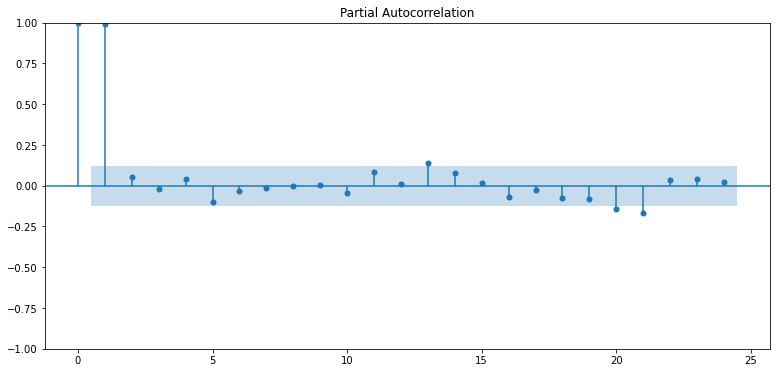

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(9, 1, 0)   Log Likelihood                 584.860
Date:                Sun, 20 Nov 2022   AIC            

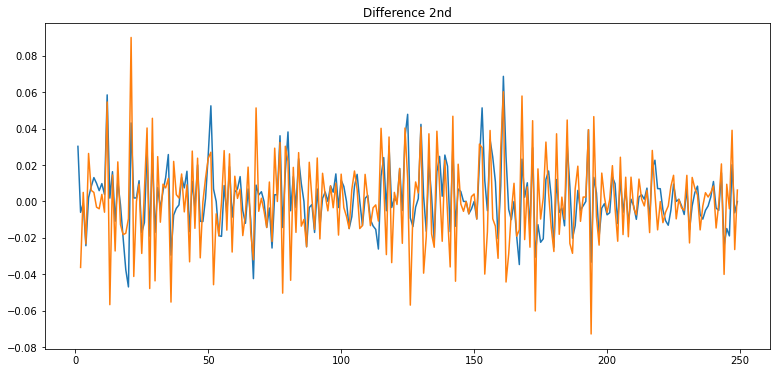

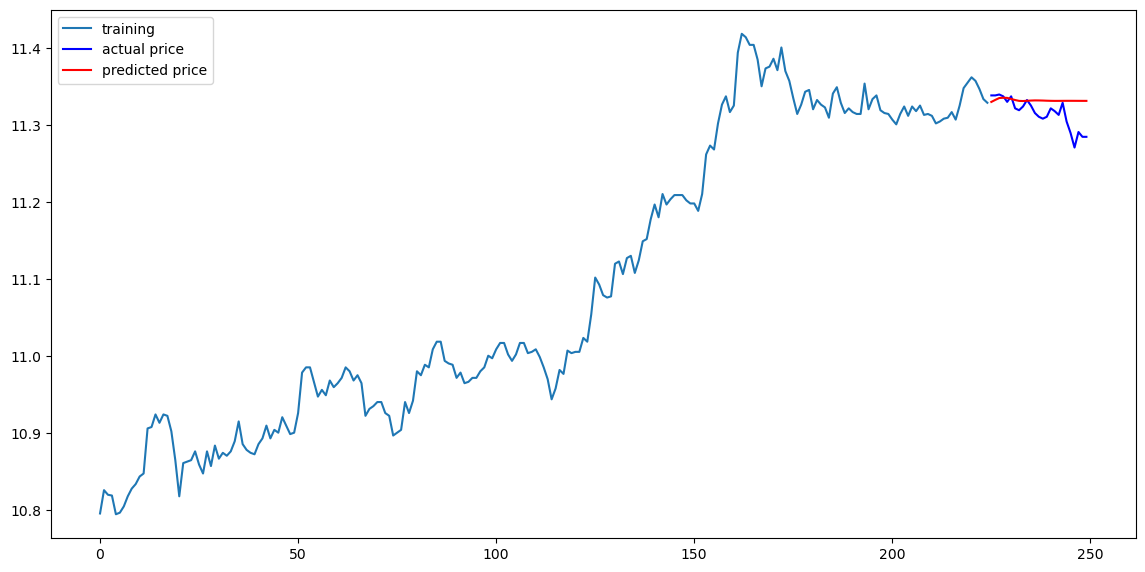

MSE:  4003150.634722723
MAE:  1497.4801804401068
RMSE:  2000.787503640185
MAPE: 1.85%


225    11.330118
226    11.332749
227    11.335152
228    11.335539
229    11.335356
230    11.333978
231    11.332588
232    11.331476
233    11.331281
234    11.331588
235    11.331895
236    11.332084
237    11.332024
238    11.331897
239    11.331689
240    11.331544
241    11.331468
242    11.331480
243    11.331524
244    11.331551
245    11.331557
246    11.331536
247    11.331513
248    11.331489
249    11.331476
Name: predicted_mean, dtype: float64

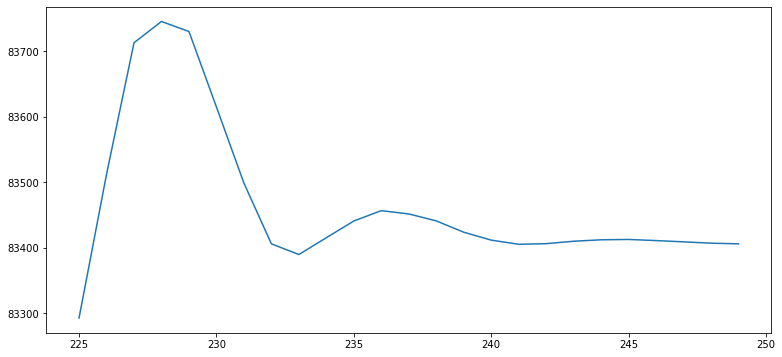

In [46]:
stock_prediction(samsung_df)    

## TESLA 주가분석

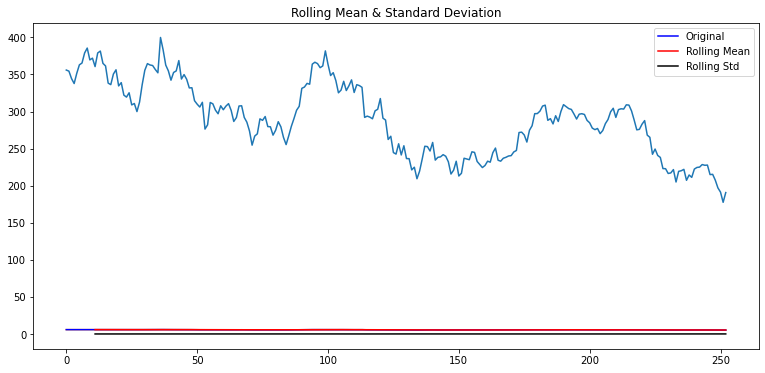

Results of Dickey-Fuller Test:
Test Statistic                  -1.433208
p-value                          0.566256
#Lags Used                      10.000000
Number of Observations Used    242.000000
Critical Value (1%)             -3.457664
Critical Value (5%)             -2.873559
Critical Value (10%)            -2.573175
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -5.199370
p-value                          0.000009
#Lags Used                       9.000000
Number of Observations Used    213.000000
Critical Value (1%)             -3.461429
Critical Value (5%)             -2.875207
Critical Value (10%)            -2.574054
dtype: float64


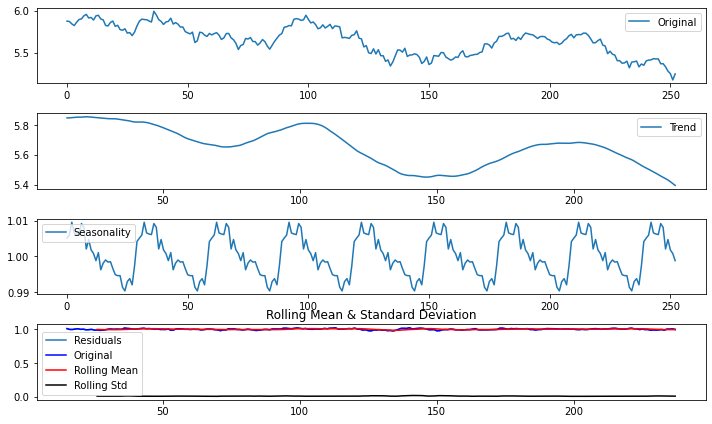

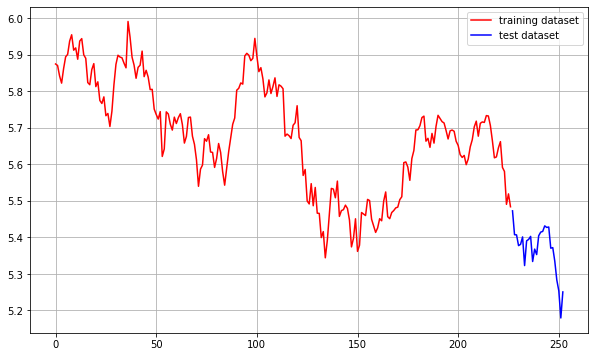

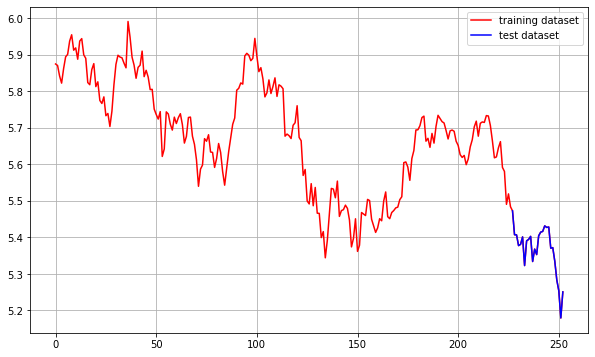

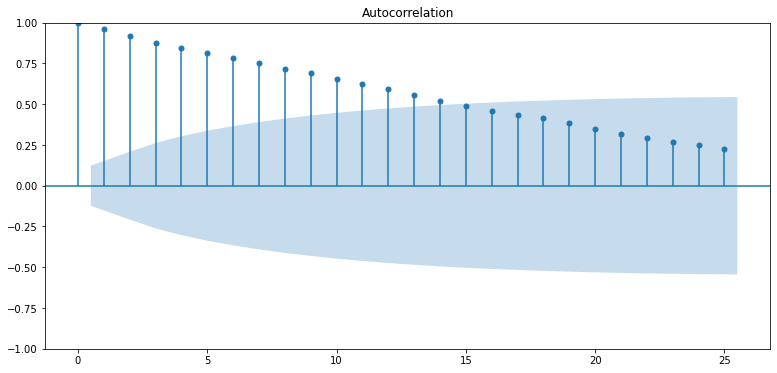

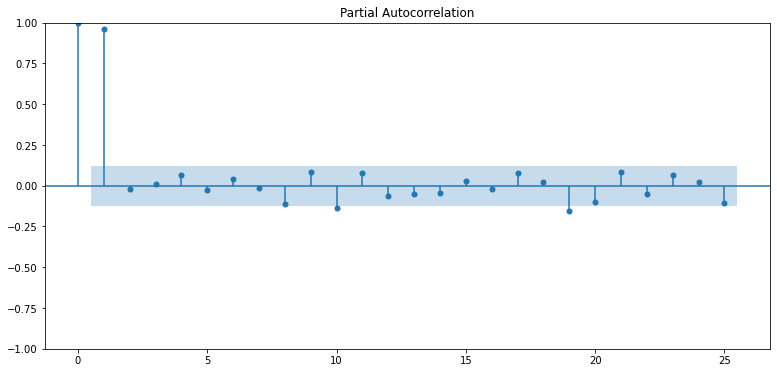

Results of Dickey-Fuller Test:
Test Statistic                  -4.835993
p-value                          0.000046
#Lags Used                       9.000000
Number of Observations Used    242.000000
Critical Value (1%)             -3.457664
Critical Value (5%)             -2.873559
Critical Value (10%)            -2.573175
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -8.053630e+00
p-value                        1.715576e-12
#Lags Used                     1.000000e+01
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(9, 1, 0)   Log Likelihood                 411.913
Date:                Sun, 20 Nov 2022   AIC                          

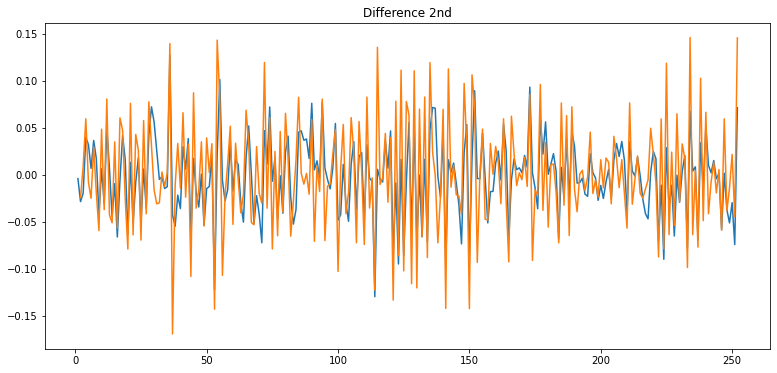

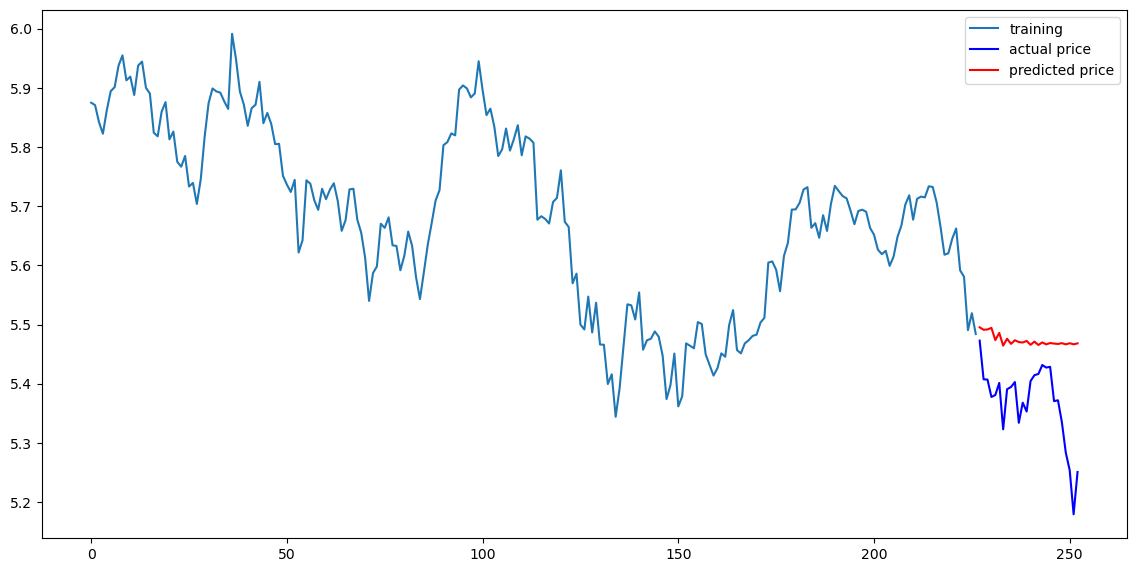

MSE:  702.4745644924968
MAE:  23.28115453369492
RMSE:  26.50423672721961
MAPE: 11.27%


227    5.495310
228    5.491193
229    5.491740
230    5.494384
231    5.473763
232    5.485840
233    5.464385
234    5.476029
235    5.467398
236    5.473502
237    5.470443
238    5.469600
239    5.472396
240    5.465705
241    5.471183
242    5.465491
243    5.469831
244    5.466512
245    5.468793
246    5.467882
247    5.467220
248    5.468596
249    5.466535
250    5.468488
251    5.466602
252    5.468237
Name: predicted_mean, dtype: float64

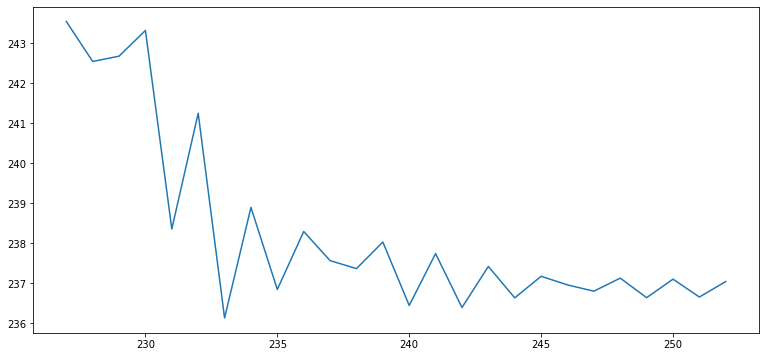

In [47]:
stock_prediction(tesla_df)   

## Unity 주가분석

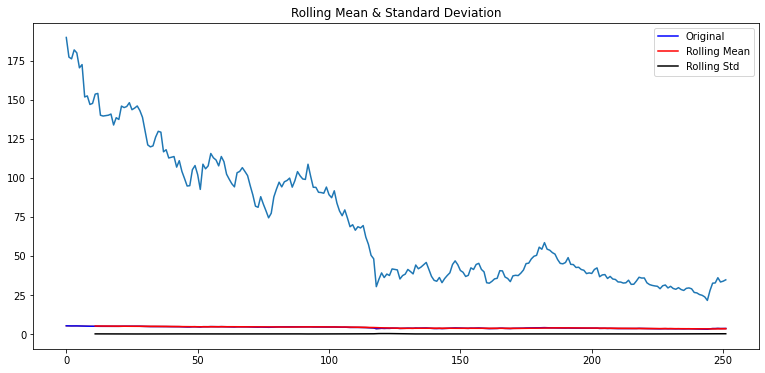

Results of Dickey-Fuller Test:
Test Statistic                  -1.743334
p-value                          0.408935
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -5.605633
p-value                          0.000001
#Lags Used                      11.000000
Number of Observations Used    210.000000
Critical Value (1%)             -3.461879
Critical Value (5%)             -2.875404
Critical Value (10%)            -2.574159
dtype: float64


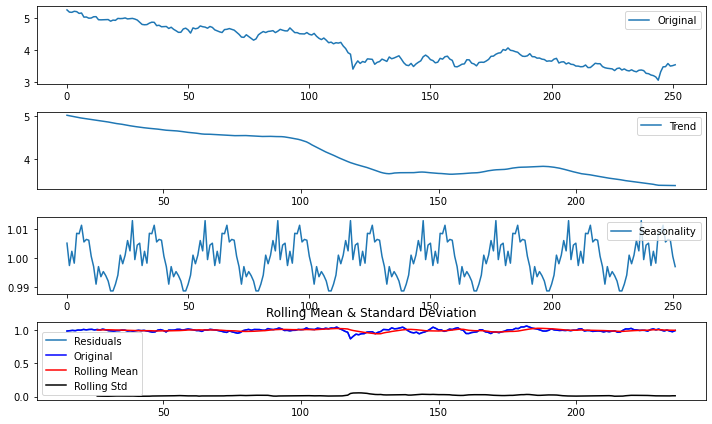

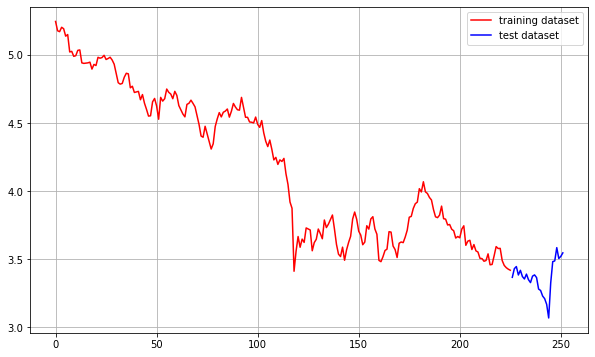

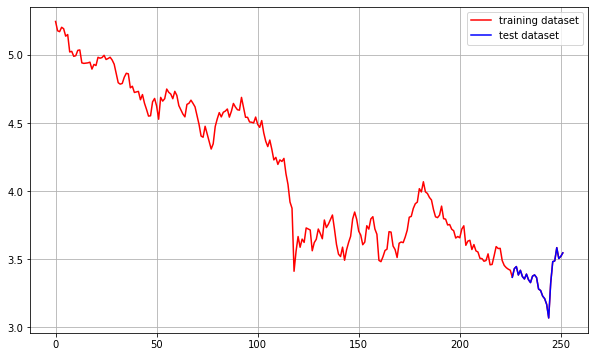

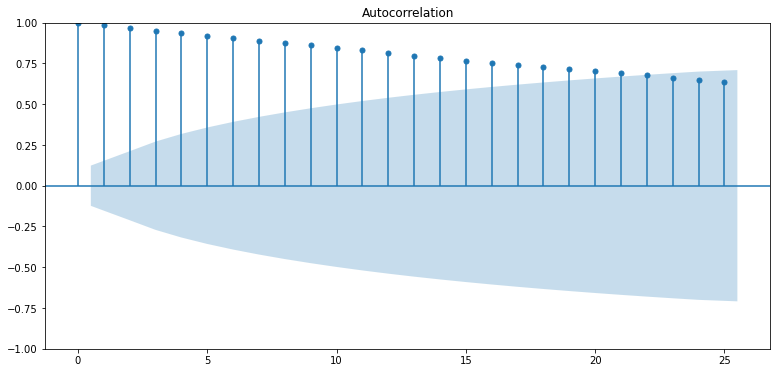

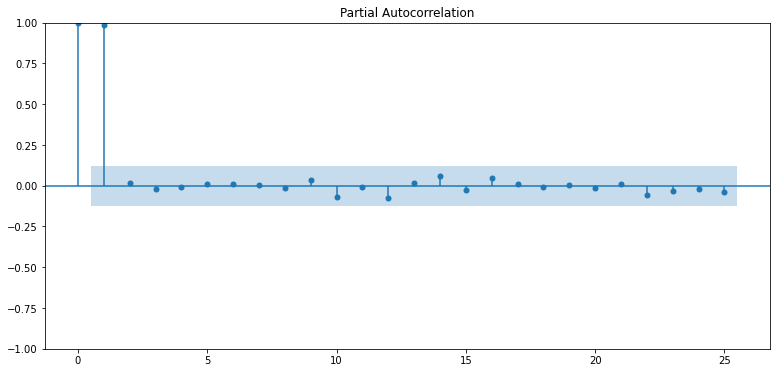

Results of Dickey-Fuller Test:
Test Statistic                -1.585742e+01
p-value                        9.296249e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -9.753759e+00
p-value                        7.888991e-17
#Lags Used                     9.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                 ARIMA(9, 1, 0)   Log Likelihood                 296.195
Date:                Sun, 20 Nov 2022   AIC            

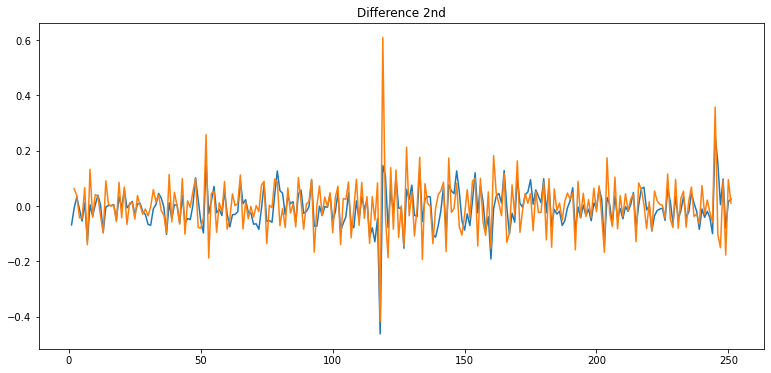

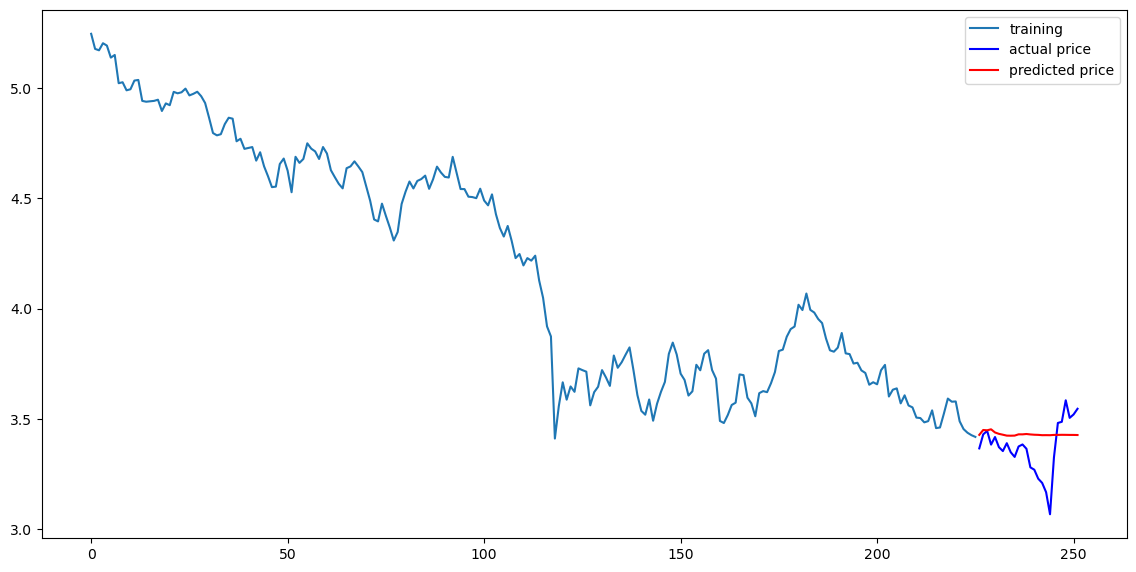

MSE:  13.568458936987877
MAE:  3.007942705485555
RMSE:  3.6835389148192634
MAPE: 11.01%


226    3.427876
227    3.449990
228    3.448564
229    3.453074
230    3.438751
231    3.432499
232    3.428541
233    3.424458
234    3.424100
235    3.424576
236    3.430268
237    3.430204
238    3.431795
239    3.429797
240    3.428495
241    3.427850
242    3.426462
243    3.426637
244    3.426382
245    3.427664
246    3.427723
247    3.428106
248    3.427943
249    3.427621
250    3.427584
251    3.427169
Name: predicted_mean, dtype: float64

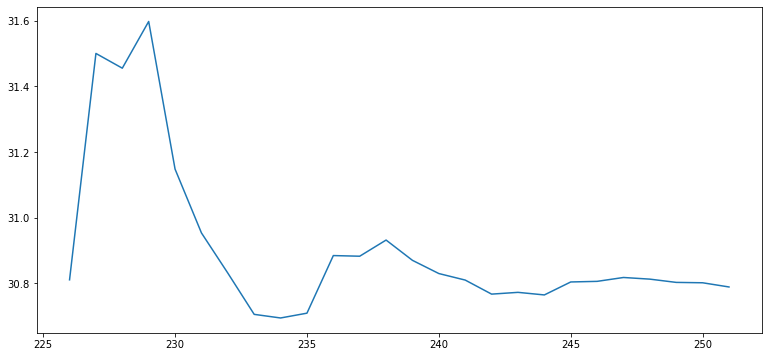

In [48]:
stock_prediction(u_df) 

## Luminar Technology 주가분석

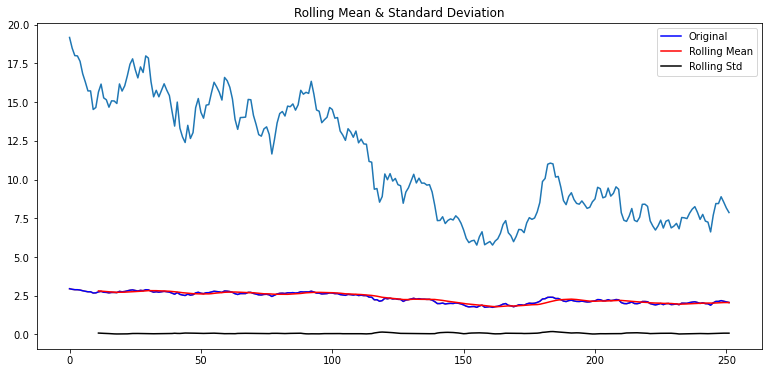

Results of Dickey-Fuller Test:
Test Statistic                  -1.754507
p-value                          0.403270
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -5.617430
p-value                          0.000001
#Lags Used                       1.000000
Number of Observations Used    220.000000
Critical Value (1%)             -3.460428
Critical Value (5%)             -2.874769
Critical Value (10%)            -2.573821
dtype: float64


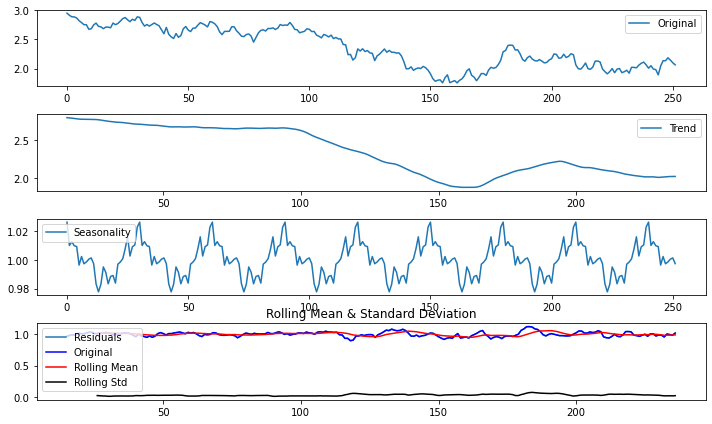

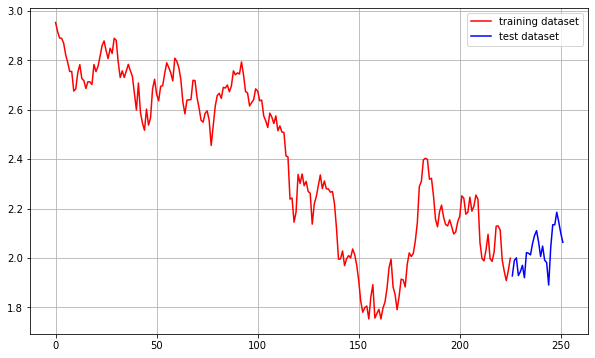

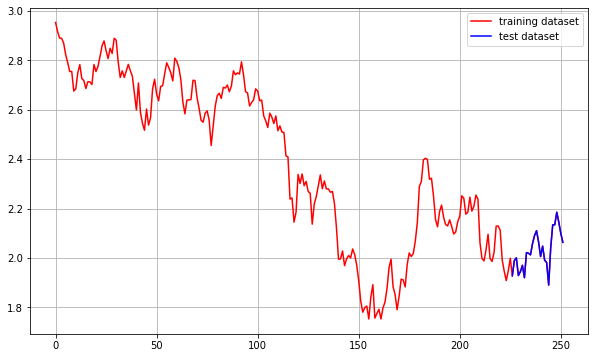

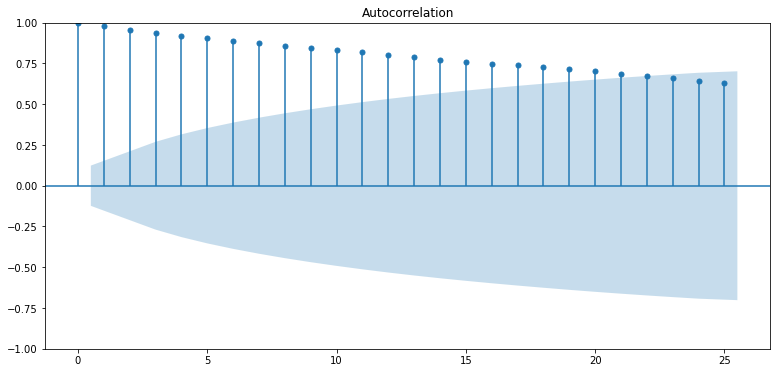

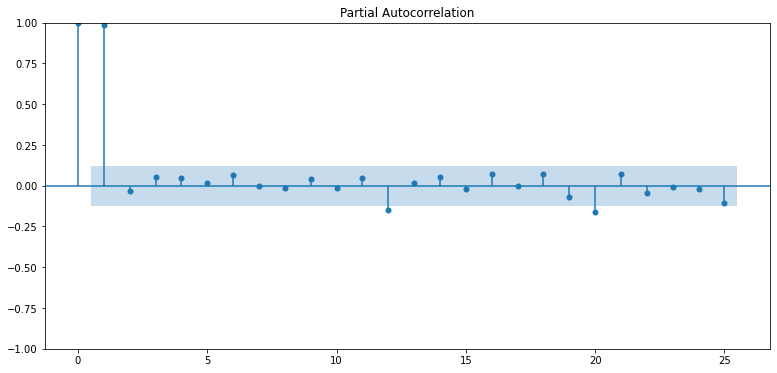

Results of Dickey-Fuller Test:
Test Statistic                -1.473264e+01
p-value                        2.645067e-27
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -9.575531e+00
p-value                        2.228710e-16
#Lags Used                     9.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                 ARIMA(9, 1, 0)   Log Likelihood                 337.829
Date:                Sun, 20 Nov 2022   AIC            

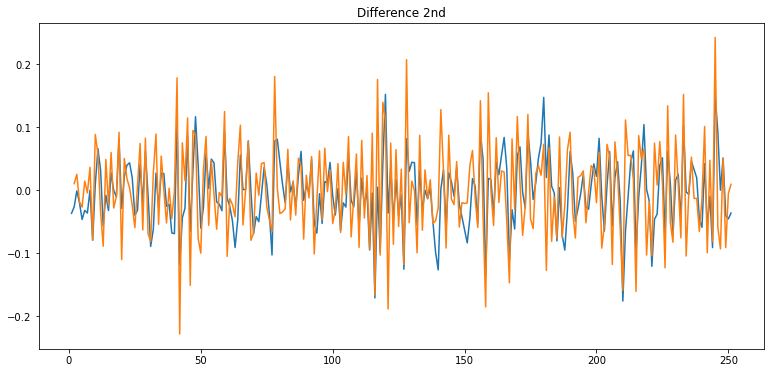

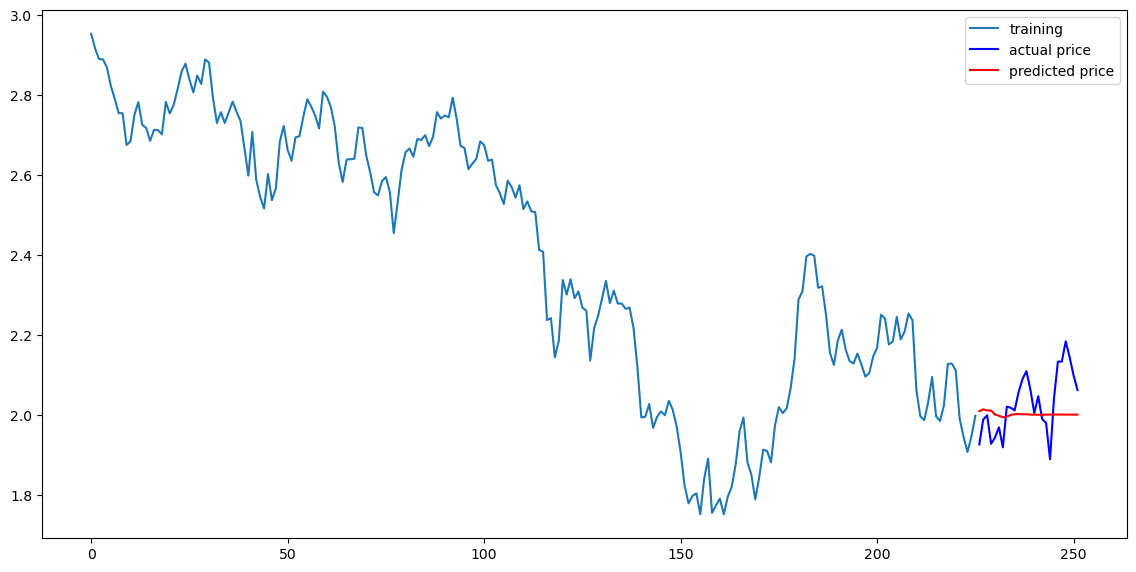

MSE:  0.3939959376018428
MAE:  0.5030082518806807
RMSE:  0.6276909570814628
MAPE: 6.42%


226    2.010475
227    2.014707
228    2.012325
229    2.011809
230    2.001631
231    1.998948
232    1.995023
233    1.996853
234    2.000818
235    2.002708
236    2.002979
237    2.002578
238    2.002588
239    2.001714
240    2.001555
241    2.001238
242    2.001310
243    2.001562
244    2.001787
245    2.001825
246    2.001779
247    2.001781
248    2.001708
249    2.001695
250    2.001671
251    2.001676
Name: predicted_mean, dtype: float64

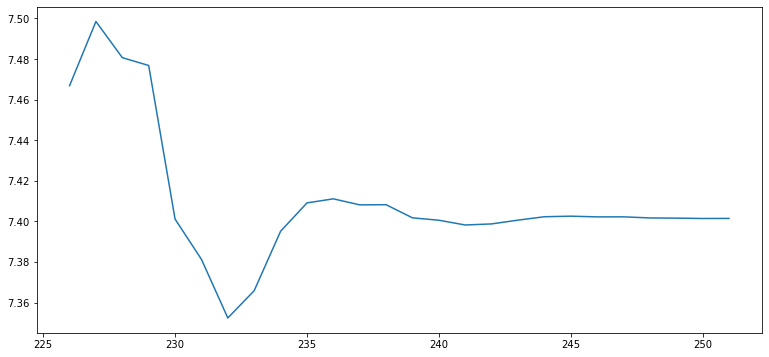

In [49]:
stock_prediction(lazr_df) 

## Microsoft corp. 주가분석

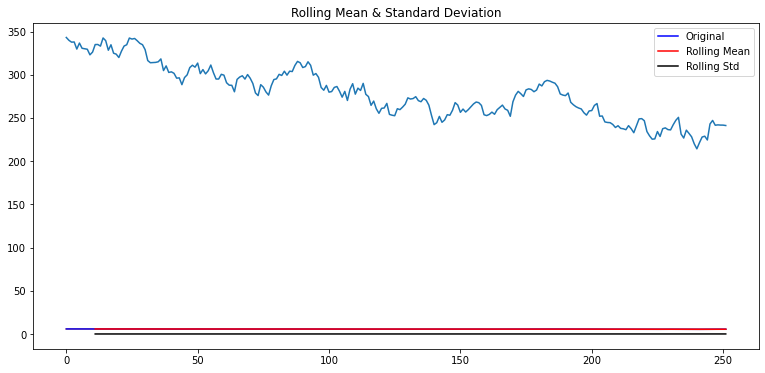

Results of Dickey-Fuller Test:
Test Statistic                  -1.899186
p-value                          0.332444
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -5.957450e+00
p-value                        2.076982e-07
#Lags Used                     9.000000e+00
Number of Observations Used    2.120000e+02
Critical Value (1%)           -3.461578e+00
Critical Value (5%)           -2.875272e+00
Critical Value (10%)          -2.574089e+00
dtype: float64


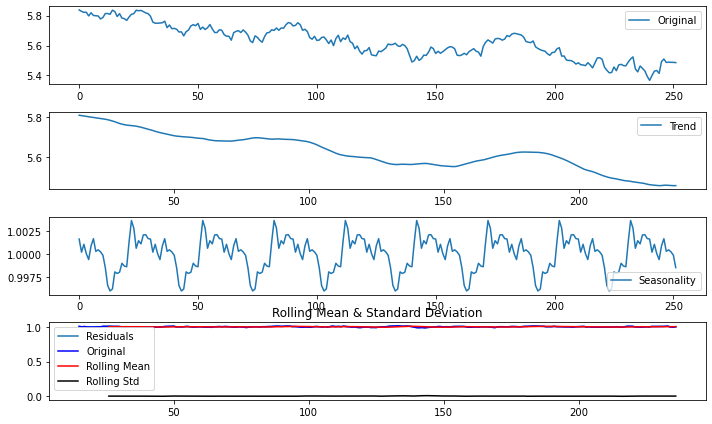

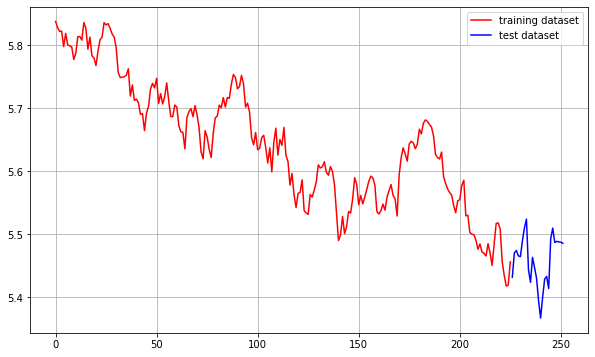

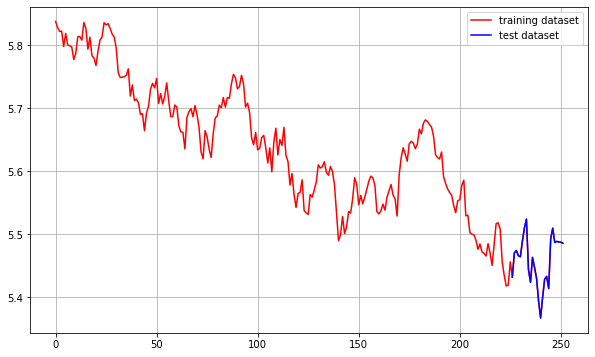

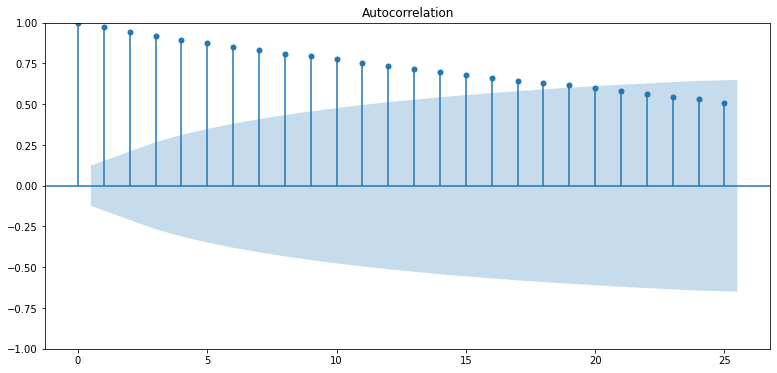

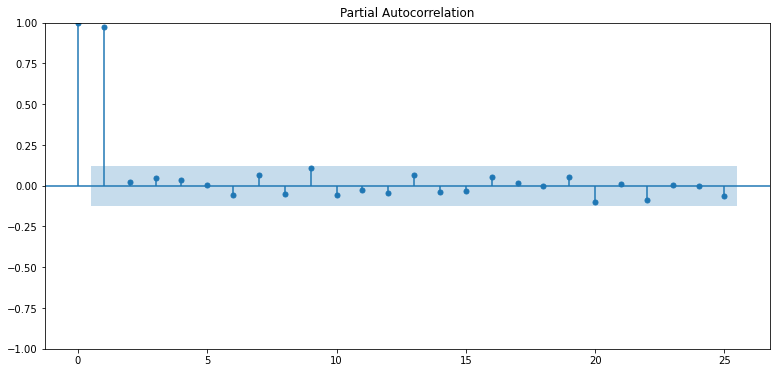

Results of Dickey-Fuller Test:
Test Statistic                -1.634575e+01
p-value                        2.965657e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -8.148805e+00
p-value                        9.822498e-13
#Lags Used                     1.100000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                 ARIMA(9, 1, 0)   Log Likelihood                 555.155
Date:                Sun, 20 Nov 2022   AIC            

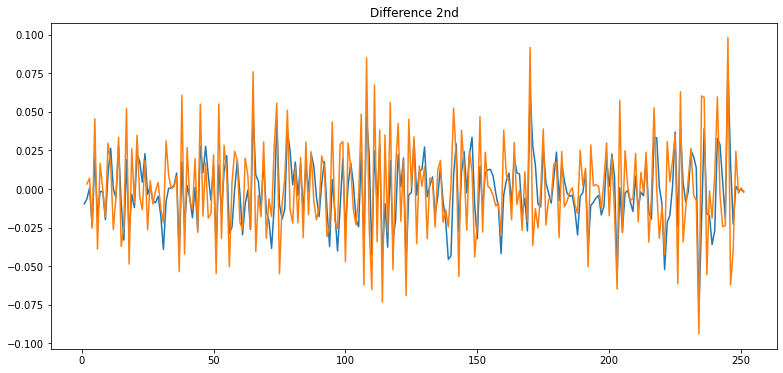

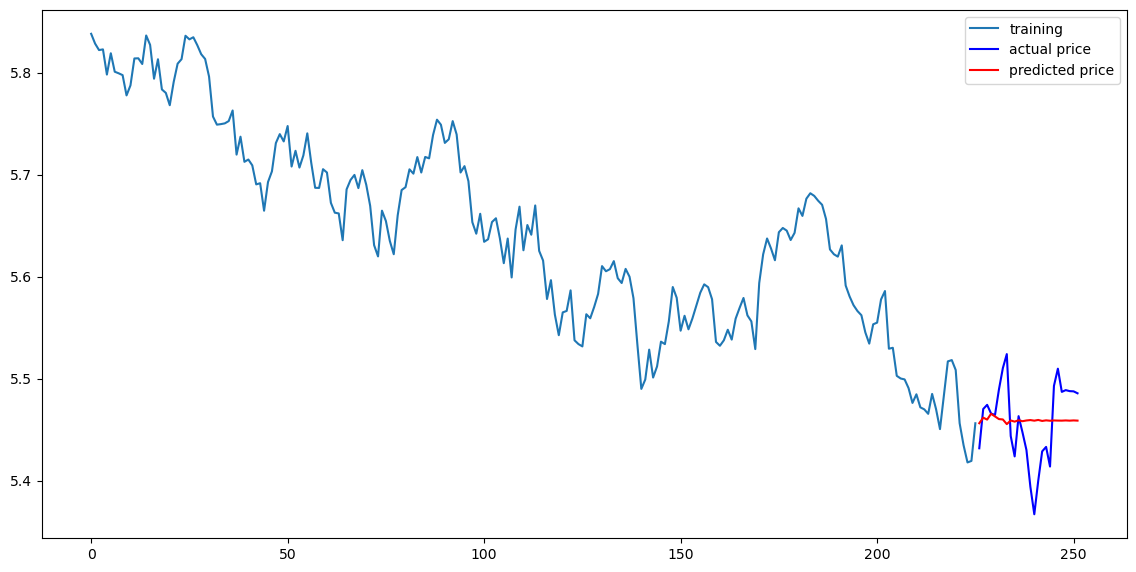

MSE:  81.24052089974688
MAE:  7.51380571596267
RMSE:  9.013352367446137
MAPE: 3.23%


226    5.456375
227    5.461812
228    5.459935
229    5.465608
230    5.463013
231    5.460425
232    5.460050
233    5.455495
234    5.459044
235    5.457943
236    5.459293
237    5.458351
238    5.459061
239    5.459455
240    5.458868
241    5.459572
242    5.458602
243    5.459182
244    5.458806
245    5.459077
246    5.458952
247    5.458896
248    5.459092
249    5.458881
250    5.459111
251    5.458915
Name: predicted_mean, dtype: float64

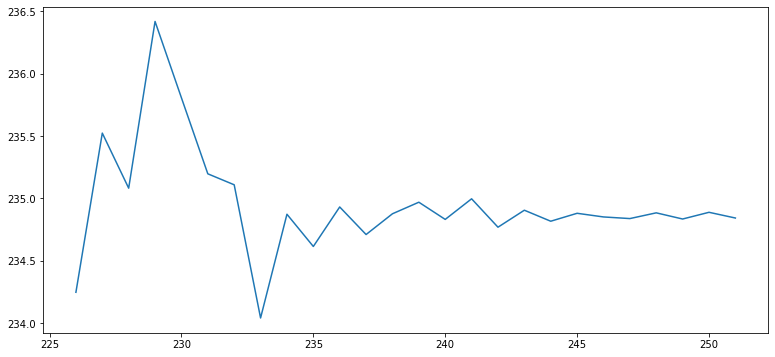

In [50]:
stock_prediction(msft_df) 

## 회고

        1. 시계열 데이터를 가져와 외부노이즈(Original 시계열에서 Trend와 Seasonality를 제거하고 난 나머지를 Residual로 안정성을 확인)를 
        제거하고 Resicual 그래프로 ARIMA 모델을 학습해보았습니다. 주가의 경우 Trend 와 Seasonality외에도 무수히많은 변수들을 고려해야하는바 
        Predicted values 와 Actual의 간극이 분명히 드러납니다. 다만 단기적인 추세를 알고자할 때 유용해보이지만 단기적이라면 그 기간을 정확히 정
        의하는 방법을 찾는 것도 의미가 있어 보입니다. 
        
        안정적 시계열이 가져야 할 요건:
        시계열의 값- X(t)의 평균과 분산이 일정 범위 안에 있어야 예측가능하다는 한계를 지니고 있다. 
        또한 X(t-h)와 X(t)는 t에 무관하게 h에 대해서만 달라지는 일정한 상관도를 가져야 한다. 즉, t와 h 는 독립적인 관계이어야 한다. 
        하지만 주식시장에서 하나의 변수는 다른변수의 영향을 받고 서로 얽히고 얽히는 관계에 있으므로 그 예측성의 신뢰성이 낮아질수 있음.
        
        하지만 적절한 모수를 찾아 MAPE가 안정적인 주식을 찾아 투자하는 것은 안정적인 투자전략으로 보입니다. 

           
        p: 자기회귀 모형(AR)의 시차 / q: 차분 누적(I) 횟수 / q: 이동평균 모형(MA)의 시차
        (case1--> p: 14, q: 1 d: 0)
        2.1 MAPE
            Samsung: 1.53%
            Tesla: 14.27%
            Unity: 10.45%
            Luminar: 6.69%
            Microsoft: 3.29%

        (case2 -->p: 9, q: 1 d: 0)
        2.2 MAPE
            Samsung: 1.85%
            Tesla: 11.27%
            Unity: 11.01%
            Luminar: 6.42%
            Microsoft: 3.23%
  